# Most Streamed Spotify Songs 2024 EDA


In [56]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import re
from collections import Counter
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [57]:
df = pd.read_csv("/Users/mani/Desktop/eda/data/Most Streamed Spotify Songs 2024.csv", encoding='latin1')

In [58]:
# Initial Data Exploration
df.info()
print('\n------ Percentage null ------\n')
print(df.isnull().sum() / len(df) * 100)
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Posts                3427 

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0


## Data Cleaning & Numeric Conversion


In [59]:
# Drop completely null column
df = df.drop(columns=['TIDAL Popularity'], errors='ignore')

# Columns to convert from string to numeric
platform_cols = [
    'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity',
    'YouTube Views', 'YouTube Likes', 'YouTube Playlist Reach',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
    'Deezer Playlist Count', 'Deezer Playlist Reach',
    'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
    'Soundcloud Streams', 'Shazam Counts'
]

# Remove commas, convert to numeric
for col in platform_cols:
    df[col] = df[col].astype(str).str.replace(',', '').replace('nan', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Summary statistics
summary = df[platform_cols].describe().transpose()
print(summary[['count', 'mean', 'min', 'max']])

                             count          mean     min           max
Spotify Streams             4487.0  4.473873e+08  1071.0  4.281469e+09
Spotify Playlist Count      4530.0  5.939083e+04     1.0  5.903920e+05
Spotify Playlist Reach      4528.0  2.334682e+07     1.0  2.623434e+08
Spotify Popularity          3796.0  6.350158e+01     1.0  9.600000e+01
YouTube Views               4292.0  4.027967e+08   913.0  1.632276e+10
YouTube Likes               4285.0  2.930049e+06    25.0  6.231118e+07
YouTube Playlist Reach      3591.0  3.439601e+08     1.0  7.289707e+09
TikTok Posts                3427.0  9.443076e+05     1.0  4.290000e+07
TikTok Likes                3620.0  1.126375e+08     3.0  2.347422e+10
TikTok Views                3619.0  1.161158e+09    19.0  2.332323e+11
Apple Music Playlist Count  4039.0  5.460312e+01     1.0  8.590000e+02
AirPlay Spins               4102.0  5.513916e+04     1.0  1.777811e+06
SiriusXM Spins              2477.0  2.573444e+02     1.0  7.098000e+03
Deezer

## Distributions of Key Metrics


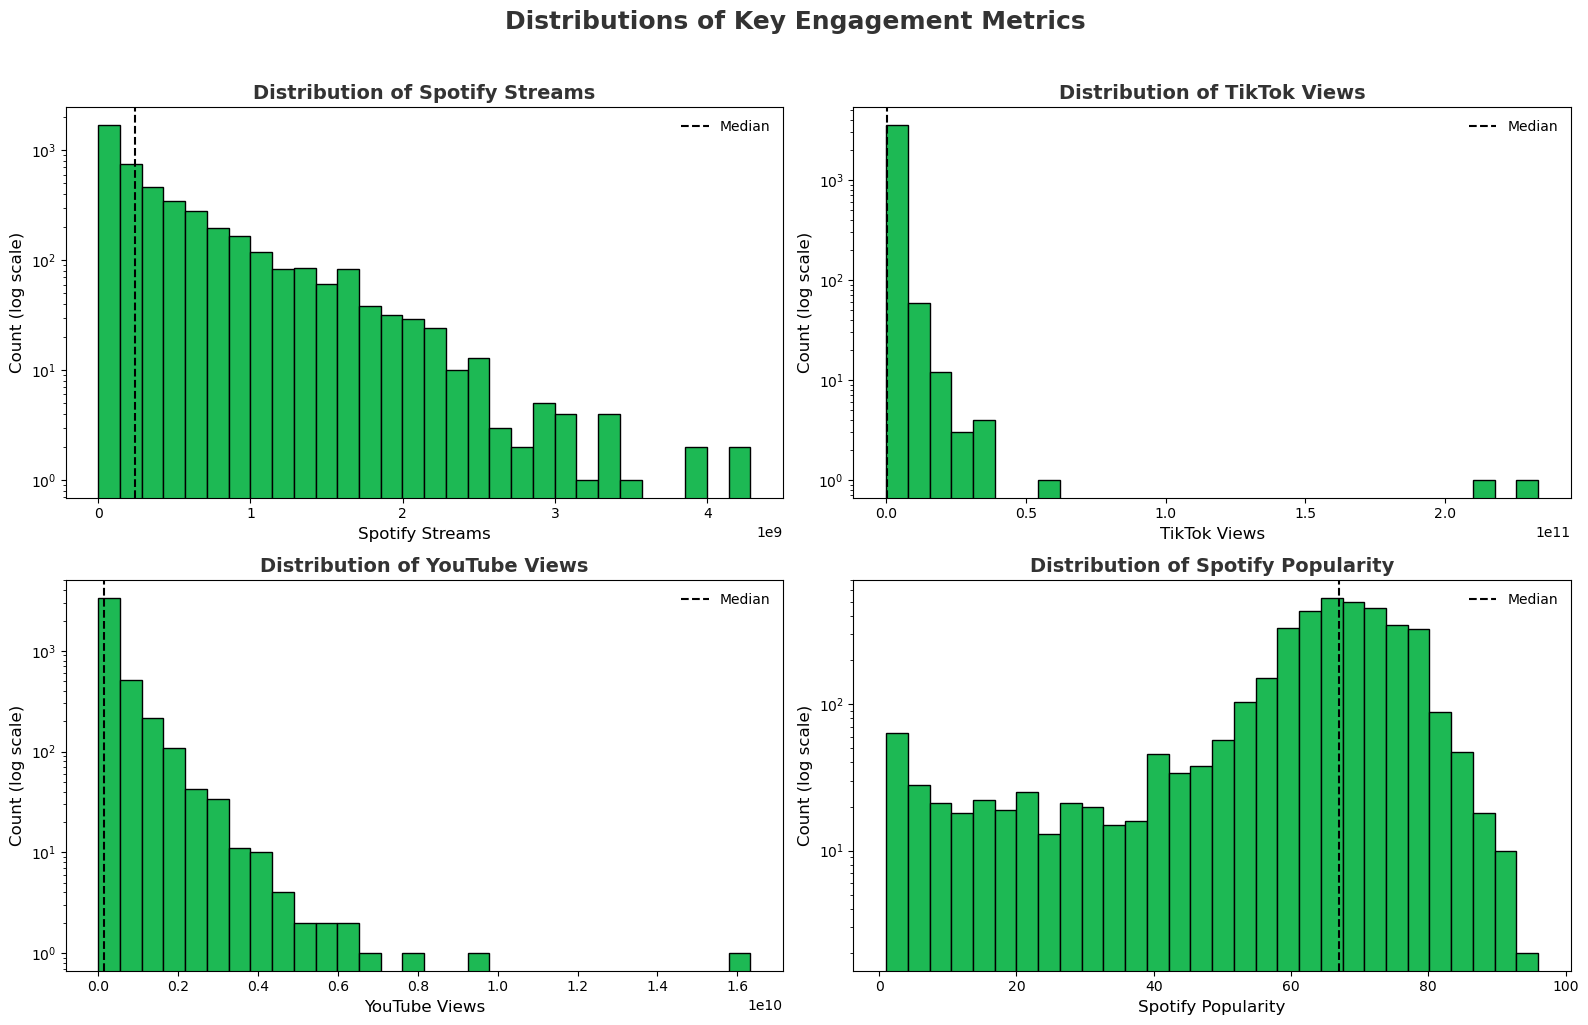

In [65]:
# Define Spotify theme colors
spotify_green = "#1DB954"
neutral_gray = "#333333"
spotify_dark_gray = "#191414"
spotify_light_gray = "#B3B3B3"

cols_to_plot = ['Spotify Streams', 'TikTok Views', 'YouTube Views', 'Spotify Popularity']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, col in zip(axes.flat, cols_to_plot):
    data = df[col].dropna()

    counts, bin_edges = np.histogram(data, bins=30)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    ax.bar(bin_centers, counts, width=np.diff(bin_edges), align='center',
           color=spotify_green, edgecolor='black', log=True)

    median_val = np.median(data)
    ax.axvline(median_val, color='black', linestyle='--', linewidth=1.5, label='Median')

    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold', color=neutral_gray)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count (log scale)', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

    ax.legend(frameon=False, fontsize=10, loc='upper right')

plt.suptitle('Distributions of Key Engagement Metrics', fontsize=18, fontweight='bold', color=neutral_gray, y=1.02)
plt.tight_layout()
plt.show()


#### Insights:

- Spotify Streams, TiKTok Views, and YouTube Views seem pretty heavily right skewed, especially TikTok views. This indicating that most views/streams tend to be lower, except for the few viral videos in the tail.
- Spotify Popularity though looks more normal, with a slight right skew.


## Correlations and Cross-Platform Relationships


In [61]:
corr_cols = ['Spotify Streams', 'TikTok Views', 'YouTube Views', 'Spotify Popularity', 'Spotify Playlist Count']
corr_matrix = df[corr_cols].corr()
print("Correlation Matrix:")
corr_matrix

Correlation Matrix:


,Spotify Streams,TikTok Views,YouTube Views,Spotify Popularity,Spotify Playlist Count
Spotify Streams,1.000000,0.030481,0.468619,0.359931,0.815083
TikTok Views,0.030481,1.000000,0.003535,-0.059513,0.035026
YouTube Views,0.468619,0.003535,1.000000,0.035983,0.322035
Spotify Popularity,0.359931,-0.059513,0.035983,1.000000,0.390597
Spotify Playlist Count,0.815083,0.035026,0.322035,0.390597,1.000000


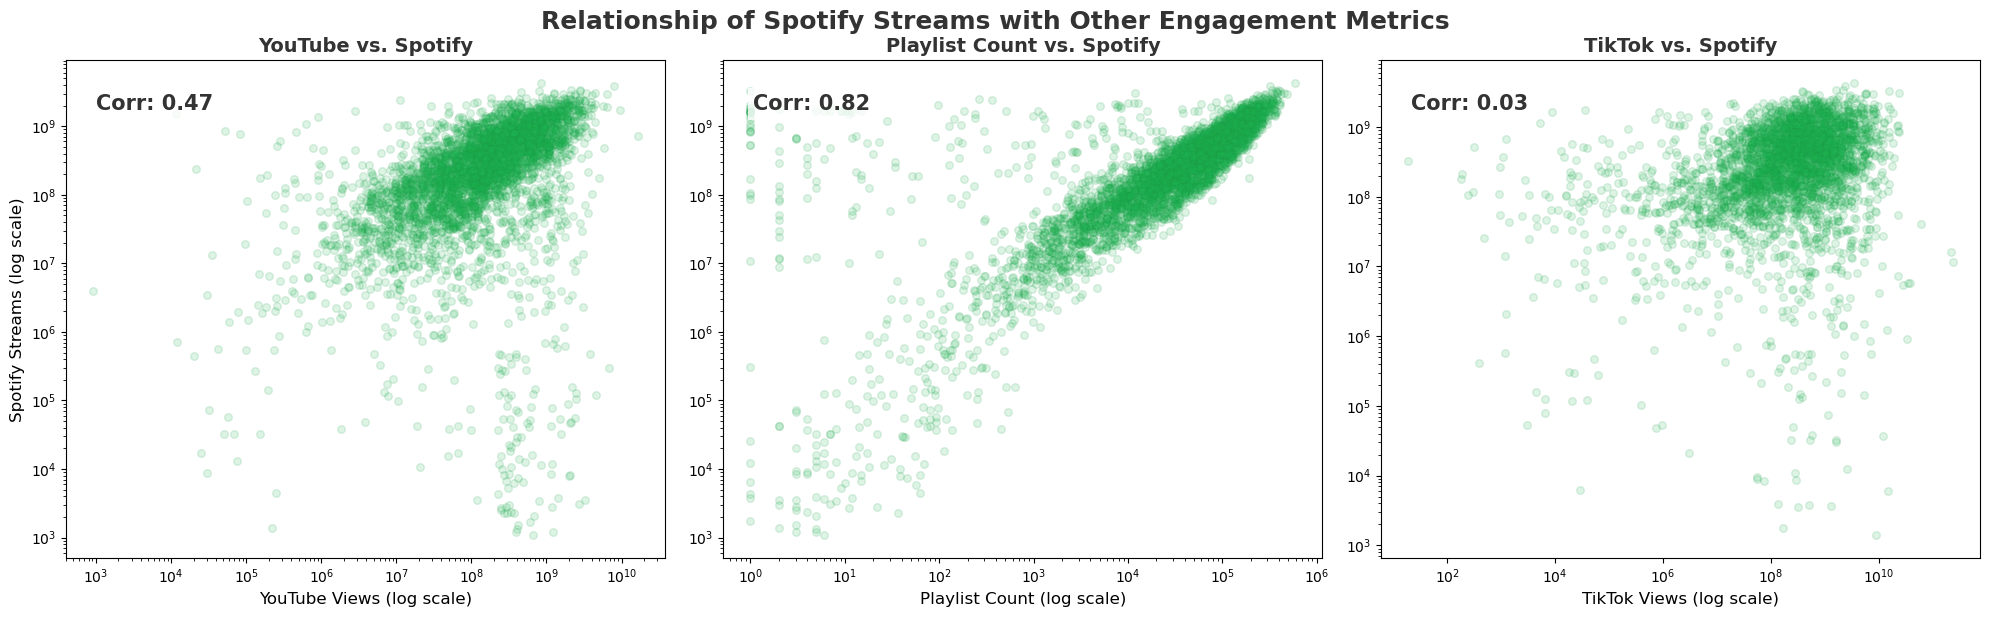

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.patch.set_facecolor('white')

pairs = [
    ('YouTube Views', 'Spotify Streams', 'YouTube Views (log scale)', 'YouTube vs. Spotify'),
    ('Spotify Playlist Count', 'Spotify Streams', 'Playlist Count (log scale)', 'Playlist Count vs. Spotify'),
    ('TikTok Views', 'Spotify Streams', 'TikTok Views (log scale)', 'TikTok vs. Spotify')
]

correlations = {x: df[x].corr(df['Spotify Streams']) for x, _, _, _ in pairs}

for ax, (x_col, y_col, xlabel, title) in zip(axs, pairs):
    ax.scatter(df[x_col], df[y_col], alpha=0.15, color=spotify_green, edgecolor='#1A9B47', s=30)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_title(title, fontsize=14, fontweight='bold', color=neutral_gray)
    ax.set_xlabel(xlabel, fontsize=12)
    if ax == axs[0]:
        ax.set_ylabel('Spotify Streams (log scale)', fontsize=12)
    else:
        ax.set_ylabel('')

    # Correlation annotation (rounded to 2 decimals) in upper left corner
    corr_val = correlations[x_col]
    ax.text(0.05, 0.9, f'Corr: {corr_val:.2f}', transform=ax.transAxes,
            fontsize=15, fontweight='bold', color=neutral_gray,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Adjust layout to avoid label overlap
plt.tight_layout()

# Main title for the figure
plt.suptitle('Relationship of Spotify Streams with Other Engagement Metrics', fontsize=18, fontweight='bold', color=neutral_gray, y=1.02)

plt.show()

#### Insights:

- Surprisingly, TiTok Views and Spotify Streams has a low correlation! Meaning a viral TikTok video doesn't mean the song will necessarily do well.
- YouTube Views seem to have more of a correlation. This could be due to music video watches.
- Spotify Playlist count has the largest correlation of 0.815.


## Outliers


Since YouTube Views is positively correlated with Spotify Streams, let's see if there are any songs that might be popular on Youtube but aren't streamed much on Spotify.


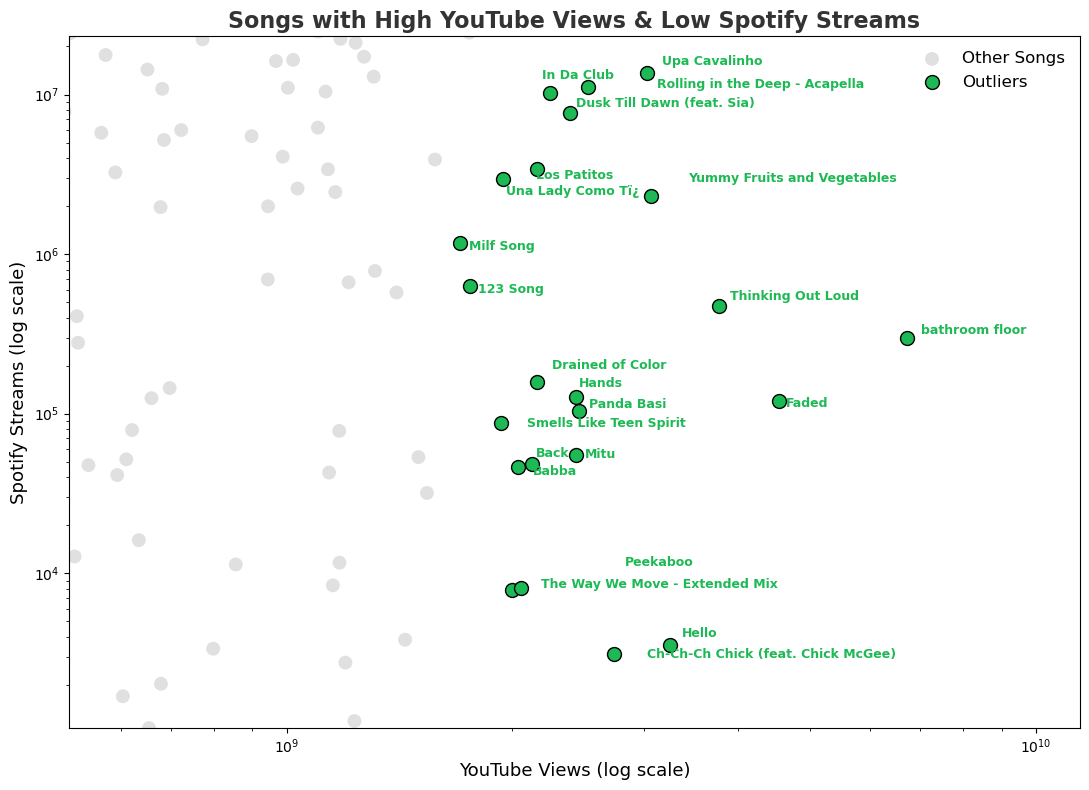

Songs with High YouTube Views and Low Spotify Streams:


,Track,Artist,YouTube Views,Spotify Streams
14,bathroom floor,Kids With Buns,6.736502e+09,297185.0
458,Faded,Benjamin Richter,4.542998e+09,120162.0
696,Thinking Out Loud,Ed Sheeran,3.777105e+09,473328.0
1273,Hello,Muramatsu Karaoke,3.250879e+09,3531.0
260,Yummy Fruits and Vegetables,D Billions,3.060919e+09,2300838.0
1491,Upa Cavalinho,Galinha Pintadinha,3.024886e+09,13615330.0
2511,Ch-Ch-Ch Chick (feat. Chick McGee),Bob and Tom,2.730591e+09,3115.0
2807,Rolling in the Deep - Acapella,Adele,2.522903e+09,11170019.0
51,Panda Basi,Mvua,2.457027e+09,104271.0
115,Hands,Dianï¿½,2.435814e+09,126914.0


In [63]:
q95_youtube = df['YouTube Views'].quantile(0.95)
q10_spotify = df['Spotify Streams'].quantile(0.10)

outliers = df[(df['YouTube Views'] > q95_youtube) & (df['Spotify Streams'] < q10_spotify)]

plt.figure(figsize=(11, 8))
plt.scatter(df['YouTube Views'], df['Spotify Streams'], alpha=0.15, label='Other Songs', color=neutral_gray, edgecolor='none', s=100)
plt.scatter(outliers['YouTube Views'], outliers['Spotify Streams'], color=spotify_green, label='Outliers', s=100, edgecolor='black')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('YouTube Views (log scale)', fontsize=13)
plt.ylabel('Spotify Streams (log scale)', fontsize=13)
plt.title('Songs with High YouTube Views & Low Spotify Streams', fontsize=16, fontweight='bold', color=neutral_gray)

x_min = max(df['YouTube Views'].min(), outliers['YouTube Views'].min() * 0.3)
x_max = min(df['YouTube Views'].max(), outliers['YouTube Views'].max() * 1.7)

y_min = max(df['Spotify Streams'].min(), outliers['Spotify Streams'].min() * 0.3)
y_max = min(df['Spotify Streams'].max(), outliers['Spotify Streams'].max() * 1.7)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

texts = []
for i, row in outliers.iterrows():
    texts.append(
        plt.text(row['YouTube Views'], row['Spotify Streams'], row['Track'],
                 fontsize=9, fontweight='bold', color=spotify_green)
    )

adjust_text(texts,
            expand_points=(1.2, 1.4),
            force_text=0.1,
            force_points=0.1)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.show()

outliers_display = outliers[['Track', 'Artist', 'YouTube Views', 'Spotify Streams']].copy()
outliers_display = outliers_display.sort_values(by='YouTube Views', ascending=False)
print("Songs with High YouTube Views and Low Spotify Streams:")
display(outliers_display)

#### Insights:

Spotify could advertise these songs on their platform/algorithm. Success on YouTube may be a good indicator of success on Spotify based on their correlation.


## Most Common Words in Track Titles


In [71]:
# PREPROCESSING STEPS 
df['clean_track'] = df['Track'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
all_words = ' '.join(df['clean_track']).split()
stopwords = list(set(STOPWORDS).union({'feat', 'ft', 'remix', 'official', 'video'}))
filtered_words = [w for w in all_words if w not in stopwords]
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)
top_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

results = []
for word in top_words_df['word']:
    df['has_word'] = df['clean_track'].apply(lambda x: word in x.split())
    avg_with = df.loc[df['has_word'], 'Spotify Streams'].mean()
    avg_without = df.loc[~df['has_word'], 'Spotify Streams'].mean()
    results.append({'word': word, 'With Word': avg_with, 'Without Word': avg_without})
results_df = pd.DataFrame(results)

plot_df = results_df.melt(id_vars='word', value_vars=['With Word', 'Without Word'],
                          var_name='Presence', value_name='Average Spotify Streams')

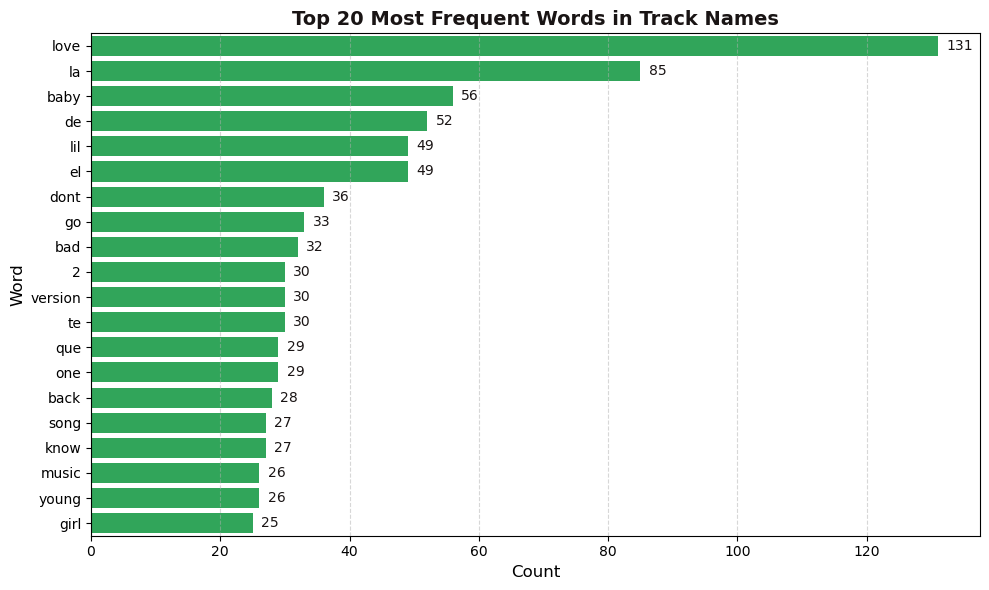

In [ ]:
# PLOT 1: Top 20 Most Frequent Words in Track Names
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_words_df,
    x='count',
    y='word',
    color=spotify_green)

plt.title('Top 20 Most Frequent Words in Track Names', fontsize=14, weight='bold', color=spotify_dark_gray)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

for index, row in top_words_df.iterrows():
    plt.text(row['count'] + max(top_words_df['count']) * 0.01, index, f"{row['count']:,}", 
             va='center', ha='left', color=spotify_dark_gray, fontsize=10)

plt.show()

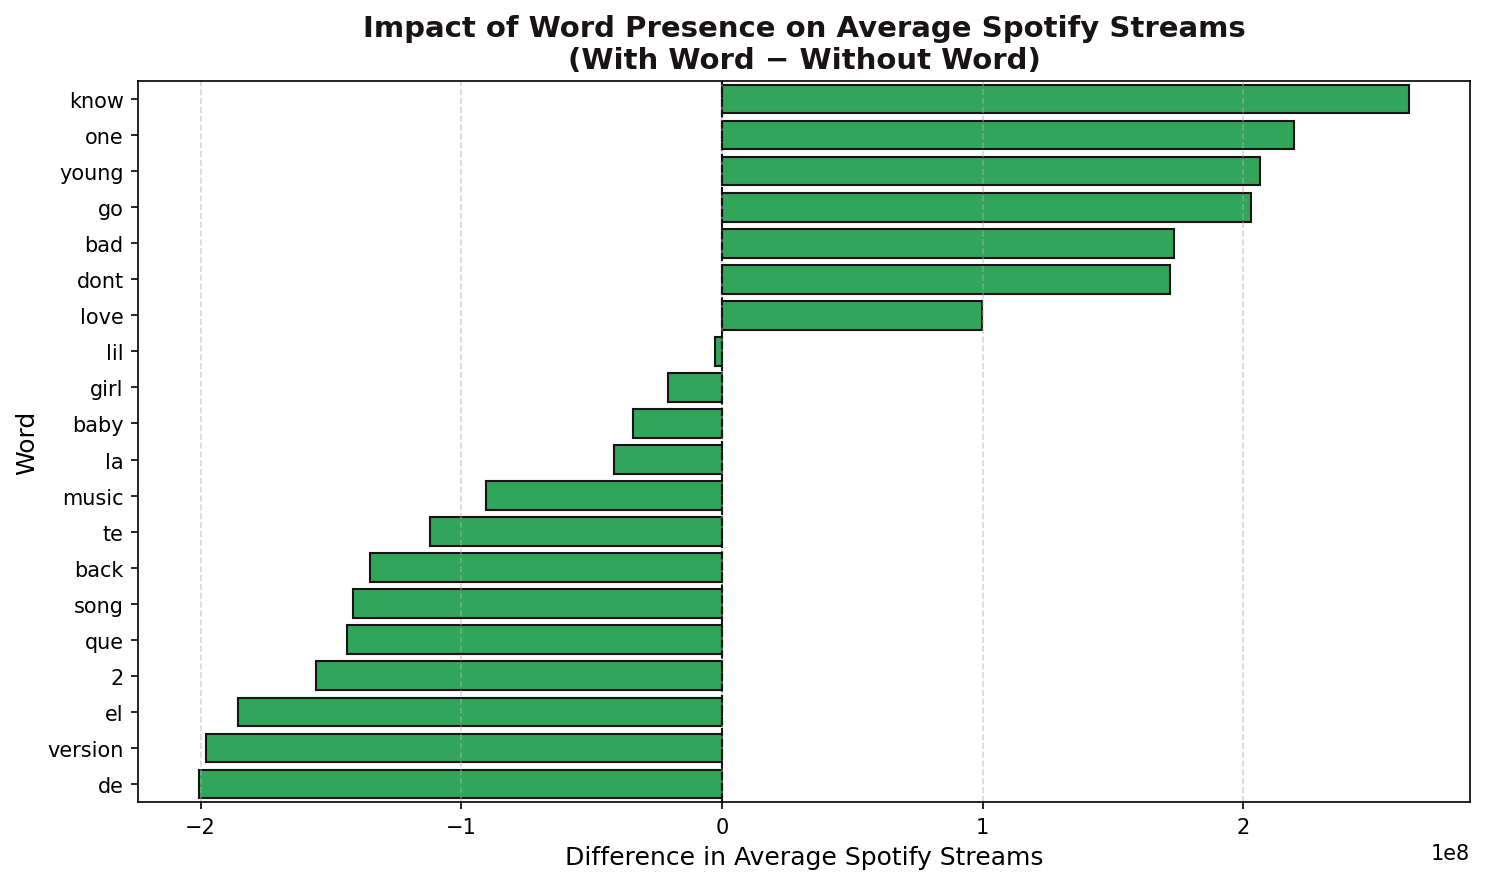

In [82]:
results_df['diff'] = results_df['With Word'] - results_df['Without Word']
results_df = results_df.sort_values('diff', ascending=False).reset_index(drop=True)


# PLOT 2: Difference in Average Streams (With and Without Top Words)
plt.figure(figsize=(10, 6), dpi=150)

sns.barplot(
    data=results_df,
    y='word',
    x='diff',
    color=spotify_green,
    edgecolor=spotify_dark_gray
)

# Reference line at zero
plt.axvline(0, color=spotify_dark_gray, linestyle='--', linewidth=1)

plt.title('Impact of Word Presence on Average Spotify Streams\n(With Word − Without Word)', 
          fontsize=14, weight='bold', color=spotify_dark_gray)
plt.xlabel('Difference in Average Spotify Streams', fontsize=12)
plt.ylabel('Word', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Insights:

- Words like "know," "one," "young," "go," "bad," "dont," and "love" are linked to significantly higher average streams (+200M+).
- Words like "music," "back," "song," "version," "de," "el," "la," "baby," "girl," and "lil" correlate with lower average streams (up to -200M).
- High-frequency positive words (e.g., "love") show moderate boosts, while some less common words (e.g., "know") have very large positive effects.
- Generic or language-specific words often relate to lower streams, suggesting audience and context matter.
